# # Project: NLP to Analyze Sentiments of Consumer Reviews of Hotels    

In this project, we use Sentiment Analysis of NLP to analyze reviews of hotels. We would like to understand if a review is positive or negative (without looking at the ratings). We will use the following libraries:
- NLTK: the most famous python module for NLP techniques
- Gensim: a topic-modelling and vector space modelling toolkit
- Scikit-learn: the most used python machine learning library

The dataset is from Kaggle and contains 515,000 customer reviews and scoring of 1493 luxury hotels offered in Booking.come across Europe.
The dataset can be found here: https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe/version/1

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Part 1: Load and Select the Data 

In [119]:
# load the data into a datadrame
reviews = pd.read_csv('/Users/Amir/PythonProjects/HotelRRDataset/Hotel_Reviews.csv')
reviews.info()

# append positive and negative reviews to have all in one column (in booking, there is two entires for 
# consumers to write positive and negative comments)
reviews["Review"] = reviews["Negative_Review"] + reviews["Positive_Review"]

# we define a bad review as the one which has overall rating of lower than 5. We label them using actual ratings 
# to compare them to our predicion to evaluate the performance 
reviews["Bad_Review?"] = reviews["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738 non-null flo

In [120]:
# Select only the relevant data for Sentiment Analysis
reviews_SA = reviews[["Review","Bad_Review?"]]
reviews_SA.head(10)

Review  Bad_Review?
0   I am so angry that i made this post available...            1
1  No Negative No real complaints the hotel was g...            0
2   Rooms are nice but for elderly a bit difficul...            0
3   My room was dirty and I was afraid to walk ba...            1
4   You When I booked with your company on line y...            0
5   Backyard of the hotel is total mess shouldn t...            0
6   Cleaner did not change our sheet and duvet ev...            1
7   Apart from the price for the brekfast Everyth...            0
8   Even though the pictures show very clean room...            0
9   The aircondition makes so much noise and its ...            0

In [121]:
# Sample some data to increase the computation speed
# sample 10% of the data 
reviews_SA = reviews_SA.sample(frac = 0.001, replace = False, random_state=42)

In [122]:
# Clean-up
# based on the data spec, if the reviewer does not give the negative or positive review, 
# the associated column will 'No Negative' and 'No Positive'. We need to remove them
# ro turn off the chain warning 
pd.options.mode.chained_assignment = None
reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: x.replace('No Negative','').replace('No Positive',''))
# see row two for an example 
reviews_SA.head(10)

Review  Bad_Review?
488440   Would have appreciated a shop in the hotel th...            0
274649        No tissue paper box was present at the room            0
374688                Pillows  Nice welcoming and service            0
404352   Everything including the nice upgrade The Hot...            0
451596                    Lovely hotel v welcoming staff             0
302161   They don t have free wifi The location is per...            0
317079   Room generally a bit shabby with some lack of...            0
13963    Executive rooms 9th Floor don t have a bath T...            0
159785   Pity about the two days of rain Its centralit...            0
195089   Didn t like it at all construction was in pro...            1

## Part 2: Text Preprocessing
Since, text is the most unstructured form of all the available data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

In [135]:
# Import required libraries 
import nltk
# FOR THE FIRST TIME, RUN ALL ABOVE CODE TO MAKE SURE YOU HAVE NECCESSARY NLTK MODULES
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

## Part 2A: Lower the Text

In [124]:
# lower text
def text_low(text):
    text = text.lower()
    return text 
reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: text_low(x))
reviews_SA.head(3)

Review  Bad_Review?
488440   would have appreciated a shop in the hotel th...            0
274649        no tissue paper box was present at the room            0
374688                pillows  nice welcoming and service            0

## Part 2B: Tokenize
Tokenize the text (split the text into words) and remove the punctuation

In [125]:
# tokenize text and remove puncutation
from nltk.tokenize import WhitespaceTokenizer
import string
def text_tok(text):
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    return text

reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: text_tok(x))
reviews_SA.head(3)


Review  Bad_Review?
488440  [, would, have, appreciated, a, shop, in, the,...            0
274649  [, no, tissue, paper, box, was, present, at, t...            0
374688       [, pillows, , nice, welcoming, and, service]            0

## Part 2C: Noise Removal
Remove all common words, stopwords, numbers, etc. 

In [126]:
from nltk.corpus import stopwords
def text_noise(text):
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove useless stop words like 'the', 'a' ,'this' etc.
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    return text 

reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: text_noise(x))
reviews_SA.head(3)

Review  Bad_Review?
488440  [would, appreciated, shop, hotel, sold, drinki...            0
274649                [tissue, paper, box, present, room]            0
374688                [pillows, nice, welcoming, service]            0

## Part 2D: POS Tagging
Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database

In [127]:
from nltk import pos_tag
def text_pos(text):
    text = pos_tag(text)
    return text
reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: text_pos(x))
reviews_SA.head(3)

Review  Bad_Review?
488440  [(would, MD), (appreciated, VBD), (shop, VB), ...            0
274649  [(tissue, NN), (paper, NN), (box, NN), (presen...            0
374688  [(pillows, NNS), (nice, JJ), (welcoming, VBG),...            0

## Part 2E: Lemmatize 
Lemmatization is an organized & step by step procedure of obtaining the root form of the word (e.g. rooms -> room, slept -> sleep). It makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [128]:
# WordNet® is a large lexical database of English.
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(t):
    if t.startswith('J'):
        return wordnet.ADJ
    elif t.startswith('V'):
        return wordnet.VERB
    elif t.startswith('N'):
        return wordnet.NOUN
    elif t.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# lemmatize text
def text_lem(text):
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in text]
    return text

reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: text_lem(x))
reviews_SA.head(10)

Review  Bad_Review?
488440  [would, appreciate, shop, hotel, sell, drinkin...            0
274649                [tissue, paper, box, present, room]            0
374688                   [pillow, nice, welcome, service]            0
404352  [everything, include, nice, upgrade, hotel, re...            0
451596                 [lovely, hotel, v, welcome, staff]            0
302161  [free, wifi, location, perfect, lot, time, wan...            0
317079  [room, generally, bit, shabby, lack, maintenan...            0
13963   [executive, room, floor, bath, website, make, ...            0
159785  [pity, two, day, rain, centrality, proximity, ...            0
195089  [like, construction, progress, stuff, lie, u, ...            1

## Part 2F: Final Clean-ups 

In [129]:
def text_cl(text):
    # remove words with only one letter
    text = [word for word in text if len(word) > 1]
    # join all
    text = " ".join(text)
    return text

reviews_SA["Review"] = reviews_SA["Review"].apply(lambda x: text_cl(x))
reviews_SA.head(3)

Review  Bad_Review?
488440  would appreciate shop hotel sell drinking wate...            0
274649                      tissue paper box present room            0
374688                        pillow nice welcome service            0
404352  everything include nice upgrade hotel revamp s...            0
451596                         lovely hotel welcome staff            0
302161  free wifi location perfect lot time want look ...            0
317079  room generally bit shabby lack maintenance cru...            0
13963   executive room floor bath website make look li...            0
159785  pity two day rain centrality proximity destina...            0
195089  like construction progress stuff lie vacancy l...            1
477589  free upgrade executive double room complementa...            0
456271        location breakfast friendly staff nice room            0
306957  pool small kind chemical much chlorine top loc...            0

## Part 3: Feature Engineering on Text Data

## Part 3A: Sentiment Analysis by Vader
Vader is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:
- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores

In [134]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Vader sentiment analysis 
sa_v = SentimentIntensityAnalyzer()
reviews_SA["Sentiments"] = reviews_SA["Review"].apply(lambda x: sa_v.polarity_scores(x))
reviews_SA.head(3)

# We integrate those 4 values as features in our dataset
reviews_SA = pd.concat([reviews_SA.drop(['Sentiments'], axis=1), reviews_SA['Sentiments'].apply(pd.Series)], axis=1)
reviews_SA.head(3)

Review  Bad_Review?  \
488440  would appreciate shop hotel sell drinking wate...            0   
274649                      tissue paper box present room            0   
374688                        pillow nice welcome service            0   

        compound    neg    neu    pos  
488440    0.9889  0.016  0.536  0.449  
274649    0.0000  0.000  1.000  0.000  
374688    0.7003  0.000  0.256  0.744

## Part 3B: Add More Features 

In [136]:
# add number of characters column
reviews_SA["N_ch"] = reviews_SA["Review"].apply(lambda x: len(x))
# add number of words column
reviews_SA["N_w"] = reviews_SA["Review"].apply(lambda x: len(x.split(" ")))
reviews_SA.head(3)

Review  Bad_Review?  \
488440  would appreciate shop hotel sell drinking wate...            0   
274649                      tissue paper box present room            0   
374688                        pillow nice welcome service            0   

        compound    neg    neu    pos  N_ch  N_w  
488440    0.9889  0.016  0.536  0.449   412   63  
274649    0.0000  0.000  1.000  0.000    29    5  
374688    0.7003  0.000  0.256  0.744    27    4

## Part 3D: Word Embedding (Doc2Vec)
In NLP, we often map words into vectors that contains numeric values so that machine can understand it. The aim of word embedding is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are widely used in deep learning models such as CNN and RNN. Two state-of-the-art word embedding methods are Word2Vec and FastText.

Word2Vec leverages the context of the target words. It is a two-layer neural network that processes text. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep networks can understand. It uses the surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation. The Word2Vec package from Gensim library creates a numerical vector representation of every word in the corpus by using the contexts in which they appear.

There are two types of Word2Vec: a shallow neural network model called "Continuous Bag of Words" and another shallow neural network model called "Skip-gram".

Word2Vec


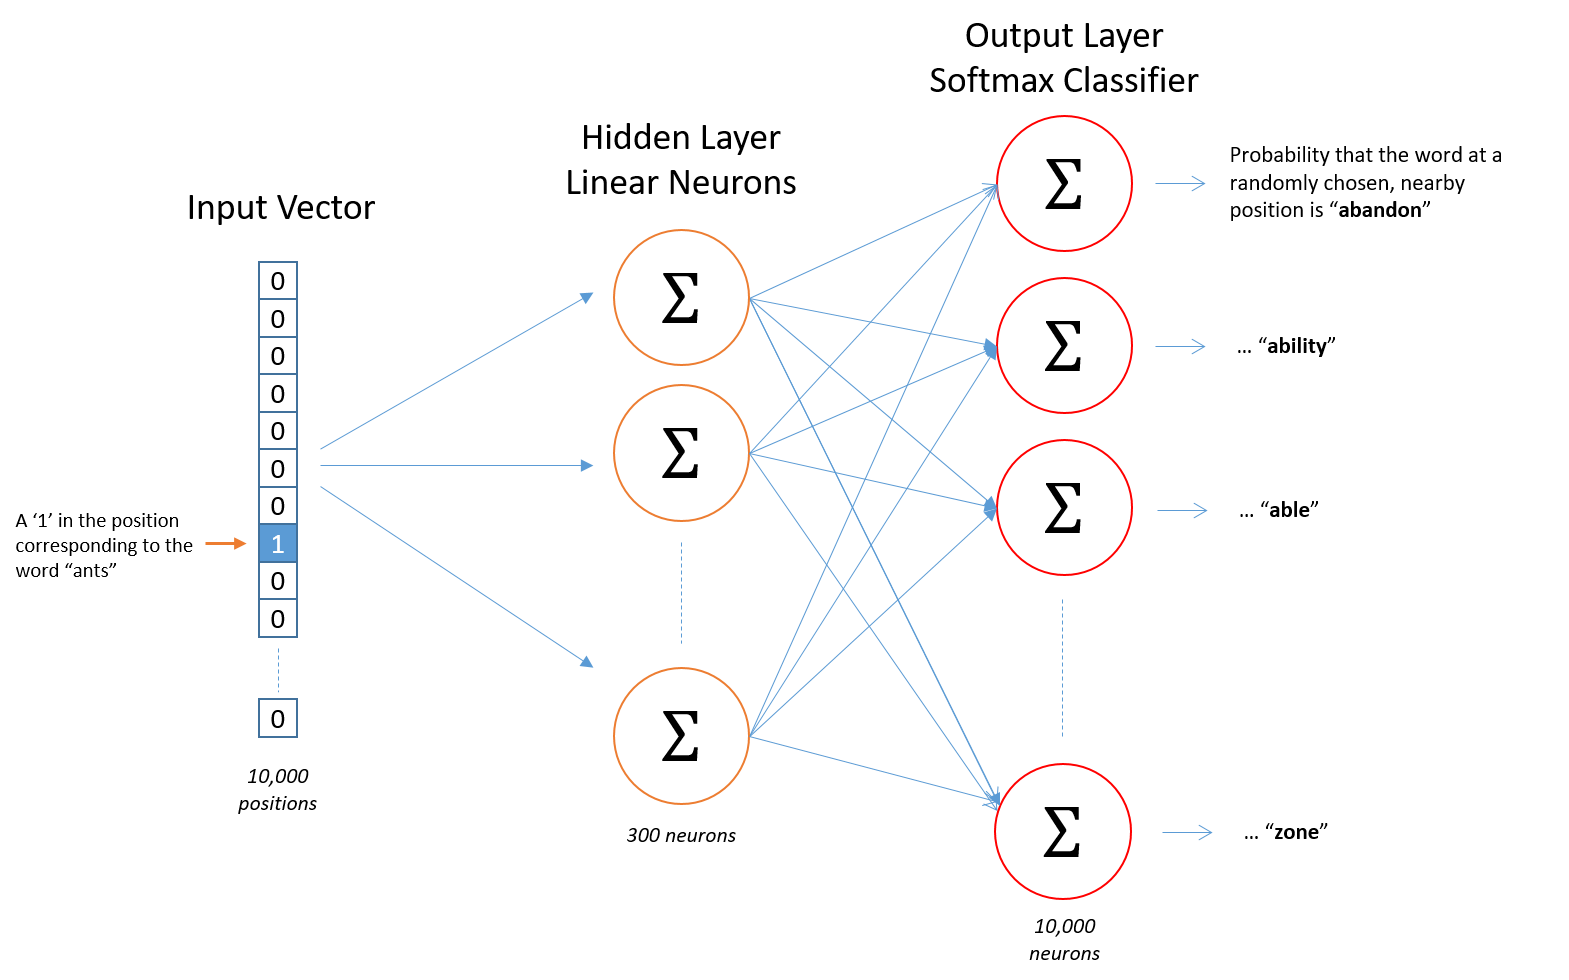

In [142]:
print("Word2Vec")
from IPython.display import Image
Image('/Users/Amir/PythonProjects/HotelRRDataset/skip_gram_net_arch.png')

Continous Bag of Words


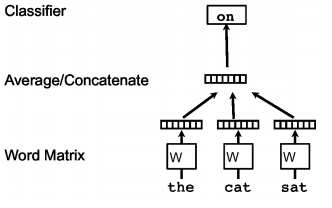

In [145]:
print("Continous Bag of Words")
from IPython.display import Image
Image('/Users/Amir/PythonProjects/HotelRRDataset/CBW.png')


The goal of doc2vec is to create a numeric representation of a document, regardless of its length. But unlike words, documents do not come in logical structures such as words, so the another method has to be found. doc2vec uses word2vec model, and added another vector. 

It is a small extension to the CBOW model. But instead of using just words to predict the next word, we also added another feature vector, which is document-unique.

So, when training the word vectors W, the document vector D is trained as well, and in the end of training, it holds a numeric representation of the document.

The model below is called Distributed Memory version of Paragraph Vector (PV-DM). It acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

doc2Vec


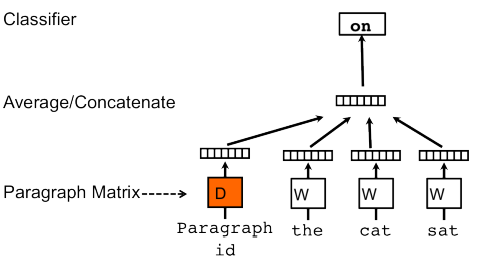

In [144]:
print("doc2Vec")
from IPython.display import Image
Image('/Users/Amir/PythonProjects/HotelRRDataset/doc2vec.png')

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

## Part 5: 

## Part 6: 